In [1]:
import pandas as pd
import numpy as np

import boto3
import io

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Create function to load s3 files from AWS
def load_s3_file(file_name, s3, bucket_name, df_name):
    # Downloading the file from S3 and parsing it into a dataframe
    s3.download_file(bucket_name, file_name, file_name)
    
    # Low memory is set to False because columns have mixed data types
    df_name = pd.read_csv(file_name, index_col=False, low_memory=False)
    return df_name 

In [3]:
# Load files from AWS
s3R = boto3.resource("s3")
s3 = boto3.client("s3")
bucket_name = "capstonehaystacks"

# Listing the contents of the S3 bucket
for obj in s3R.Bucket(bucket_name).objects.all():
    print(obj.key)

ACSDP5Y2021.DP04-Data.csv
ACSST5Y2021.S0101-Data.csv
ACSST5Y2021.S0801-Data.csv
ACSST5Y2021.S1901-Data.csv
GA_LISTINGS_SALES.csv
GA_LISTINGS_SALES_V2.csv
GA_listing.csv
POI_second_tab.csv
POI_with_count.csv
all_zips_grocery_store.json
all_zips_restaurant.json
atlanta-geo.csv
atlanta_cbsa_zip.csv
atlanta_hdma_2021.csv
atlanta_hdma_census_2021.csv
atlanta_hdma_tract_2021.csv
atlanta_listings.csv
census_POI_name_binary.csv
census_POI_name_capita.csv
census_POI_name_count.csv
census_all.csv
census_all_perCapita.csv
census_data
core_geo_dataset.csv
crime.csv
crime_rating_zipcode.csv
elementary_schools.csv
ga_georgia_zip_codes_geo.min.json
high_schools.csv
hmda_2017_ga_all-records_labels.csv
hmda_2021_ga_all-records_labels.csv
jason_listing.csv
listing-with-poi-distances.csv
listings_with_tract.csv
middle_schools.csv
poi-google-exploded.csv
poi_combined_haystack.csv
poi_combined_haystack_ALL.csv
poi_combined_haystack_ALL_CLEANED.csv
poi_expanded.csv
points-of-interest-google.csv
points-of-in

In [4]:
# Load S3 files to variables
census = load_s3_file("census_all.csv", s3, bucket_name, df_name="census")
census_capita = load_s3_file("census_all_perCapita.csv", s3, bucket_name, df_name="census_capita")
hdma = load_s3_file("atlanta_hdma_2021.csv", s3, bucket_name, df_name="hdma")
POI = load_s3_file("POI_second_tab.csv", s3, bucket_name, df_name="POI")

In [5]:
# drop_cols = ['total_workers', 'total_households', 'household_median_income',
#              'restaurant_above_4.7_percentage', 'restaurant_above_4.7_per_Capita', 'restaurant_below_4.7_per_Capita']
# census_capita = census_capita.drop(drop_cols, axis=1)

# Select the column to exclude
column_to_exclude = 'zipcode'

df_to_standardize = census_capita.drop(column_to_exclude, axis=1)
scaler = StandardScaler()
standardized_values = scaler.fit_transform(df_to_standardize)
census_capita_standardized = pd.DataFrame(standardized_values, columns=df_to_standardize.columns)

# Add the excluded column back to the standardized DataFrame
census_capita_standardized[column_to_exclude] = census_capita[column_to_exclude]

# Pop the excluded column and insert it at the first position
zipcode_column = census_capita_standardized.pop(column_to_exclude)
census_capita_standardized.insert(0, column_to_exclude, zipcode_column)

census_capita_standardized.head()

# Feature Selection
selected_cols = census_capita_standardized.drop('zipcode', axis=1).columns ## Investor Profile Builder
X = census_capita_standardized.drop('zipcode', axis=1).values 

k=6 # No. of zipcodes to consider
model = NearestNeighbors(n_neighbors=k)
model.fit(X)

# Define my Zip Code vals
my_zip = 30002
my_zip_vals = census_capita_standardized[census_capita_standardized['zipcode'] == my_zip].iloc[:,1:]
my_zip_vals

# Find Similar Zip Codes
new_X = my_zip_vals.values

distances, indices = model.kneighbors(new_X)
similar_zip_codes = census_capita_standardized.iloc[indices[0]]['zipcode']  

print(f"Similar Zip Codes: {similar_zip_codes}")

my_sim_zips = census_capita[census_capita['zipcode'].isin(similar_zip_codes)]
my_other_zips = census_capita[~census_capita['zipcode'].isin(similar_zip_codes)]

Similar Zip Codes: 0      30002
70     30127
30     30054
26     30044
140    30296
3      30008
Name: zipcode, dtype: int64


-----

In [6]:
# Prepare the data
my_df = census_capita.iloc[:, 1:]  # Exclude the zipcode column
my_df = my_df.dropna()  # Drop rows with missing values if any

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(my_df)

# PCA
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(scaled_data)

# # Analyze the results
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance = np.cumsum(explained_variance_ratio)
# n_components = np.argmax(cumulative_variance >= 0.95) + 1

# # Perform PCA with the desired number of components
# pca_final = PCA(n_components=n_components)
# pca_final.fit(scaled_data)

# # Transform the data to the new coordinate system
# transformed_data = pca_final.transform(scaled_data)


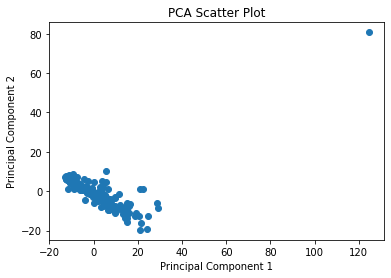

In [7]:
import matplotlib.pyplot as plt

# Plot the transformed data
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()


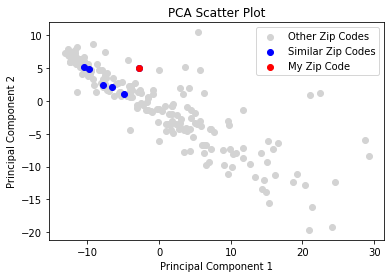

In [17]:
# Removing extreme outlier
transformed_data = transformed_data[(transformed_data[:, 0] < 40) & (transformed_data[:, 1] < 20)]

# Plot the transformed data
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], 
            color='lightgrey', label='Other Zip Codes')
plt.scatter(transformed_data[my_sim_zips.index, 0], transformed_data[my_sim_zips.index, 1], 
            color='blue', label='Similar Zip Codes')
plt.scatter(transformed_data[my_zip_vals.index, 0], transformed_data[my_zip_vals.index, 1], 
            color='red', label='My Zip Code')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')

plt.legend()

# Show the plot

plt.savefig('../visuals/PCAKNN-Visual.png')

plt.show()

-----


In [9]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Calculate the center point
# center_point = np.mean(transformed_data, axis=0)

# # Plot the transformed data
# plt.scatter(transformed_data[:, 0], transformed_data[:, 1], color='black', label='Data Points')
# plt.scatter(center_point[0], center_point[1], color='red', label='Center Point')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA Scatter Plot')



# # Draw a grey line from the center to each data point with opacity
# for i in range(transformed_data.shape[0]):
#     plt.plot([center_point[0], transformed_data[i, 0]], [center_point[1], 
#             transformed_data[i, 1]], color='grey', linestyle='--', alpha=0.5)

#     # Calculate the Euclidean distance from the center to each point
#     distance = np.linalg.norm(transformed_data[i] - center_point)

#     # Calculate the midpoint of the line
#     midpoint_x = (center_point[0] + transformed_data[i, 0]) / 2
#     midpoint_y = (center_point[1] + transformed_data[i, 1]) / 2

#     # Define the offsets for the labels
#     x_offset = 0.05  # Offset in the x-axis direction
#     y_offset = 1.5  # Offset in the y-axis direction

#     # Show the distance as text at the midpoint of the line with offsets
#     plt.text(midpoint_x + x_offset, midpoint_y + y_offset, f'{distance:.1f}', 
#              color='grey', fontsize=8, ha='center', va='center')

# plt.show()
